# Task 4
Generate a directed graph G with n nodes in a following way. For each of n nodes
choose l unique out-neighbours. For such randomly generated structure start a random walk of an agent in a randomly chosen vertex. Find the distribution after 1, 2 ,
10, 50, 100 and n steps for all configurations of parameters:

*  n = 2, 10, 20, 1000
*  l = 1, 2, 5, 10, 20, 50
*  β = 0, 0.01, 0.05, 0.1, 0.2

In [1]:
import numpy as np
import numba
from numba.typed import Dict
from numba.core import types
from matplotlib import pyplot as plt
import timeit
from time import time

In [2]:
def generate_directed_graph(n, l):
    graph = {node: set() for node in range(n)}
    for node in graph.keys():
        while len(graph[node]) < l:
            potential_neighbor = np.random.randint(n)
            if potential_neighbor != node and potential_neighbor not in graph[node]:
                graph[node].add(potential_neighbor)
    return graph

In [3]:
def convert_graph_to_numba_compatible(graph):
    G_numba = Dict.empty(key_type=types.int32, value_type=types.int32[:])
    for key, value in graph.items():
        G_numba[key] = np.array(list(value))
    return G_numba

In [4]:
@numba.njit()
def random_walk(graph, steps, taxation_rate=0):
    nodes = np.array(list(graph.keys()), dtype=types.int32)
    current_node = np.random.choice(nodes)
    for _ in range(steps):
        if np.random.random() < taxation_rate:
            current_node = np.random.choice(nodes)
        else:
            current_node = np.random.choice(graph[current_node])
    return current_node 

In [5]:
@numba.njit()
def repeat_random_walk(graph, steps, trials, taxation_rate=0):
    results = np.zeros(trials, dtype=types.int32)
    for trial in range(trials):
        results[trial] = random_walk(graph, steps, taxation_rate=taxation_rate)
    return results

In [6]:
n = 500
l = 50
steps = 100
trials = 10000

In [7]:
G = generate_directed_graph(n, l)
G_numba = convert_graph_to_numba_compatible(G)

C:\Users\thejg\Desktop\Programming\projects39\lib\site-packages\numba\typed\typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  d[key] = value


In [8]:
%%timeit
generate_directed_graph(n, l)

77 ms ± 731 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
random_walk(G_numba, steps)

19.8 µs ± 8.54 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
repeat_random_walk(G_numba, steps, trials)

79.5 ms ± 735 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
def generate_graph_for_given_n_and_l(n, l, trials):
    steps_list = [1, 2, 10, 50, 100]
    taxation_parameters = [0, 0.01, 0.05, 0.1, 0.2]
    G = generate_directed_graph(n, l)
    G_numba = convert_graph_to_numba_compatible(G)
    figure, axes = plt.subplots(len(steps_list), 1, layout='constrained', figsize=(10, 35))
    colors = ['firebrick', 'gold', 'limegreen', 'dodgerblue', 'indigo']

    for steps, ax in zip(steps_list, figure.axes):
        result_matrix = None
        times = []
        for index, taxation_parameter in enumerate(taxation_parameters):
            start_time = time()
            result = repeat_random_walk(G_numba, steps, trials, taxation_rate=taxation_parameter)[:, None]
            if result_matrix is None:
                result_matrix = result
            else:
                result_matrix = np.concatenate((result_matrix, result), axis=1)
            stop_time = time()
            times.append(stop_time - start_time)
        ax.hist(result_matrix, color=colors, alpha=0.8, bins=n, align='mid', 
                ec='black', rwidth=0.8, range=(-0.5, n - 0.5),
                label=[f'tax = {tax}, time = {time_:.4f} s' for tax, time_ in zip(taxation_parameters, times)])
        ax_title = f'{steps} steps, total time: {sum(times):.4f} s'
        ax.set(xticks=range(n), title=ax_title)
        ax.legend()
    fig_title = f'Histograms for n = {n}, l = {l} and {trials} trials'
    figure.suptitle(fig_title)
    figure.savefig(f'Task4HistogramN{n}L{l}T{trials}.png')

In [12]:
trials = 200_000

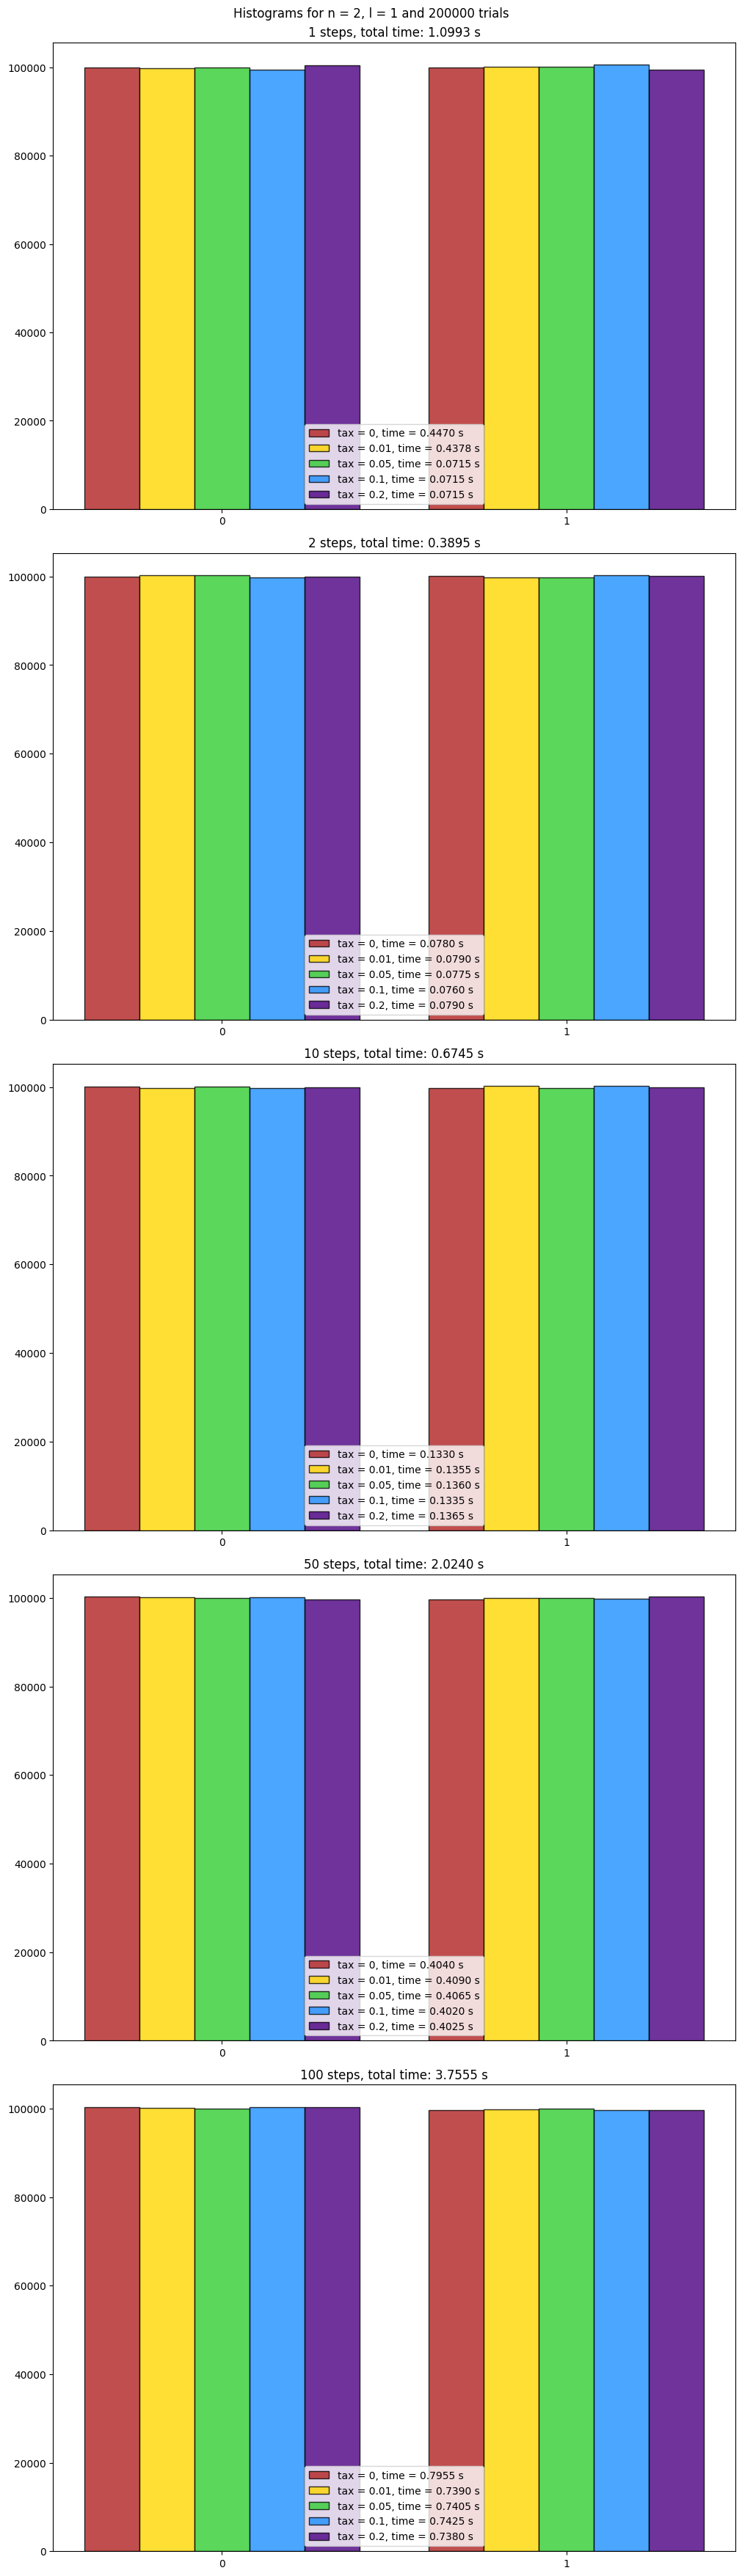

In [13]:
generate_graph_for_given_n_and_l(2, 1, trials)

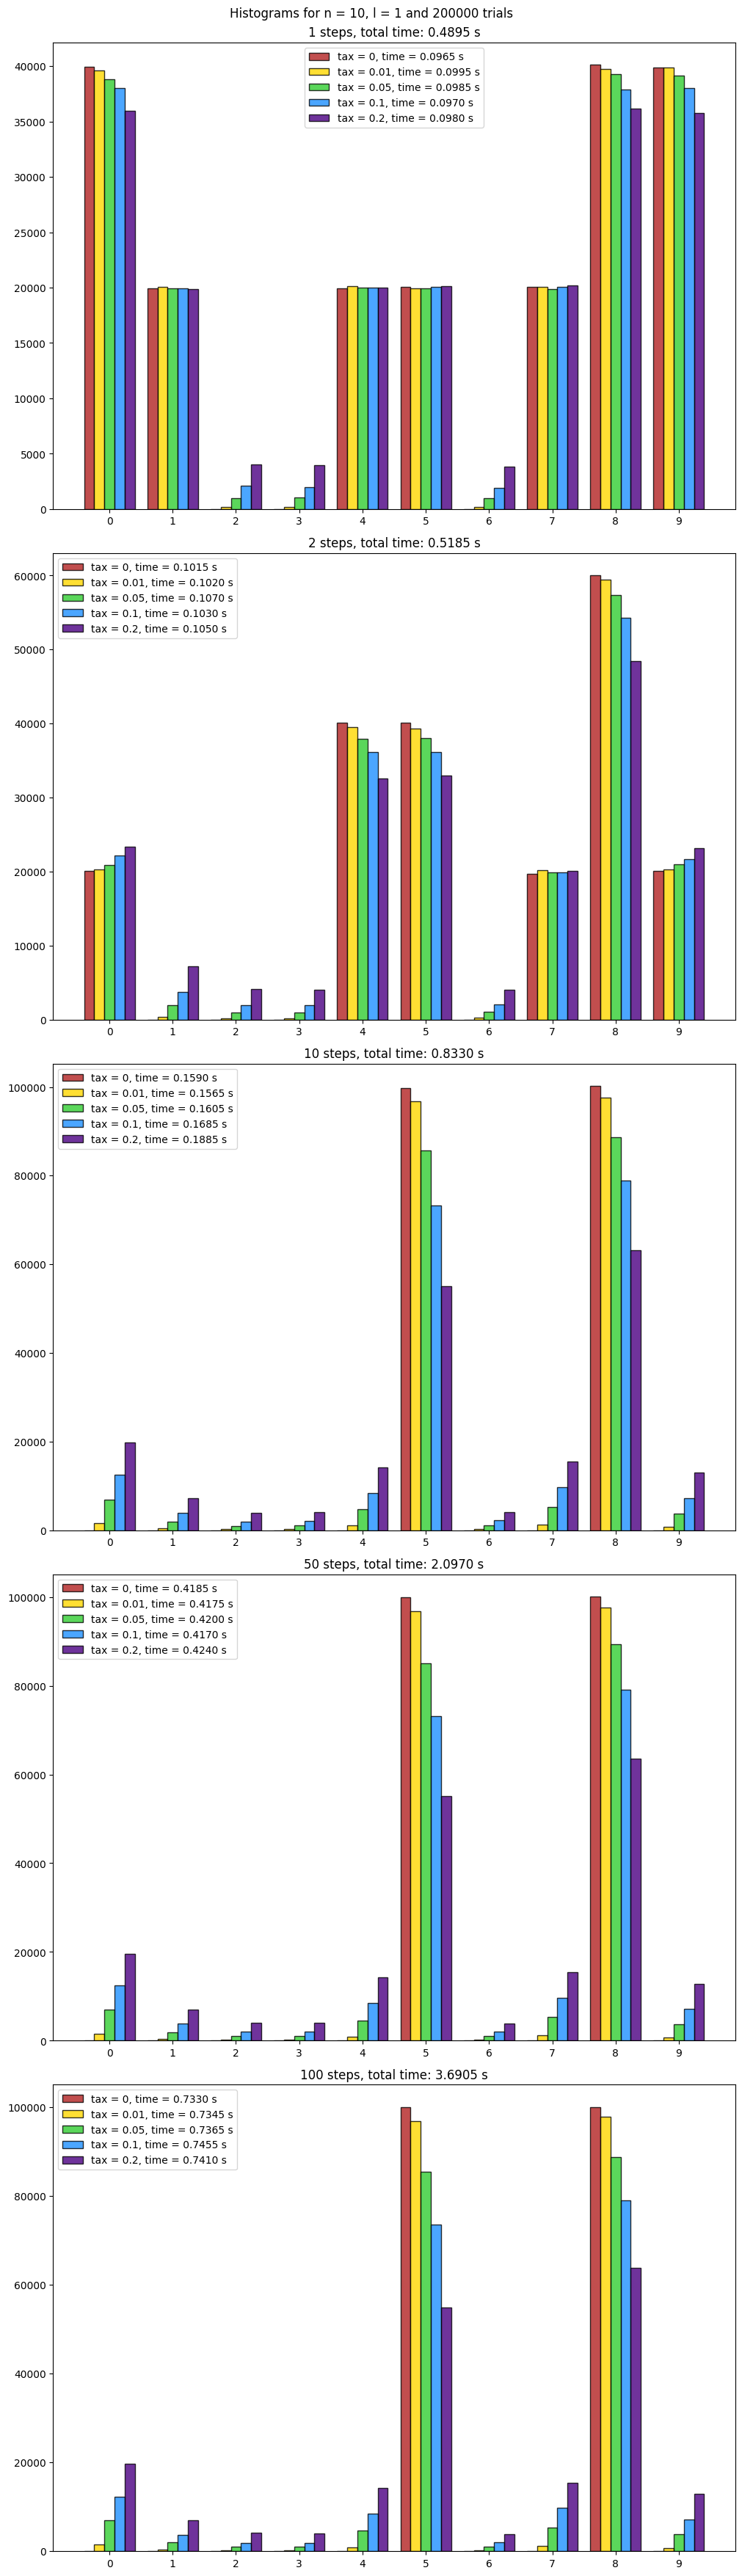

In [14]:
generate_graph_for_given_n_and_l(10, 1, trials)

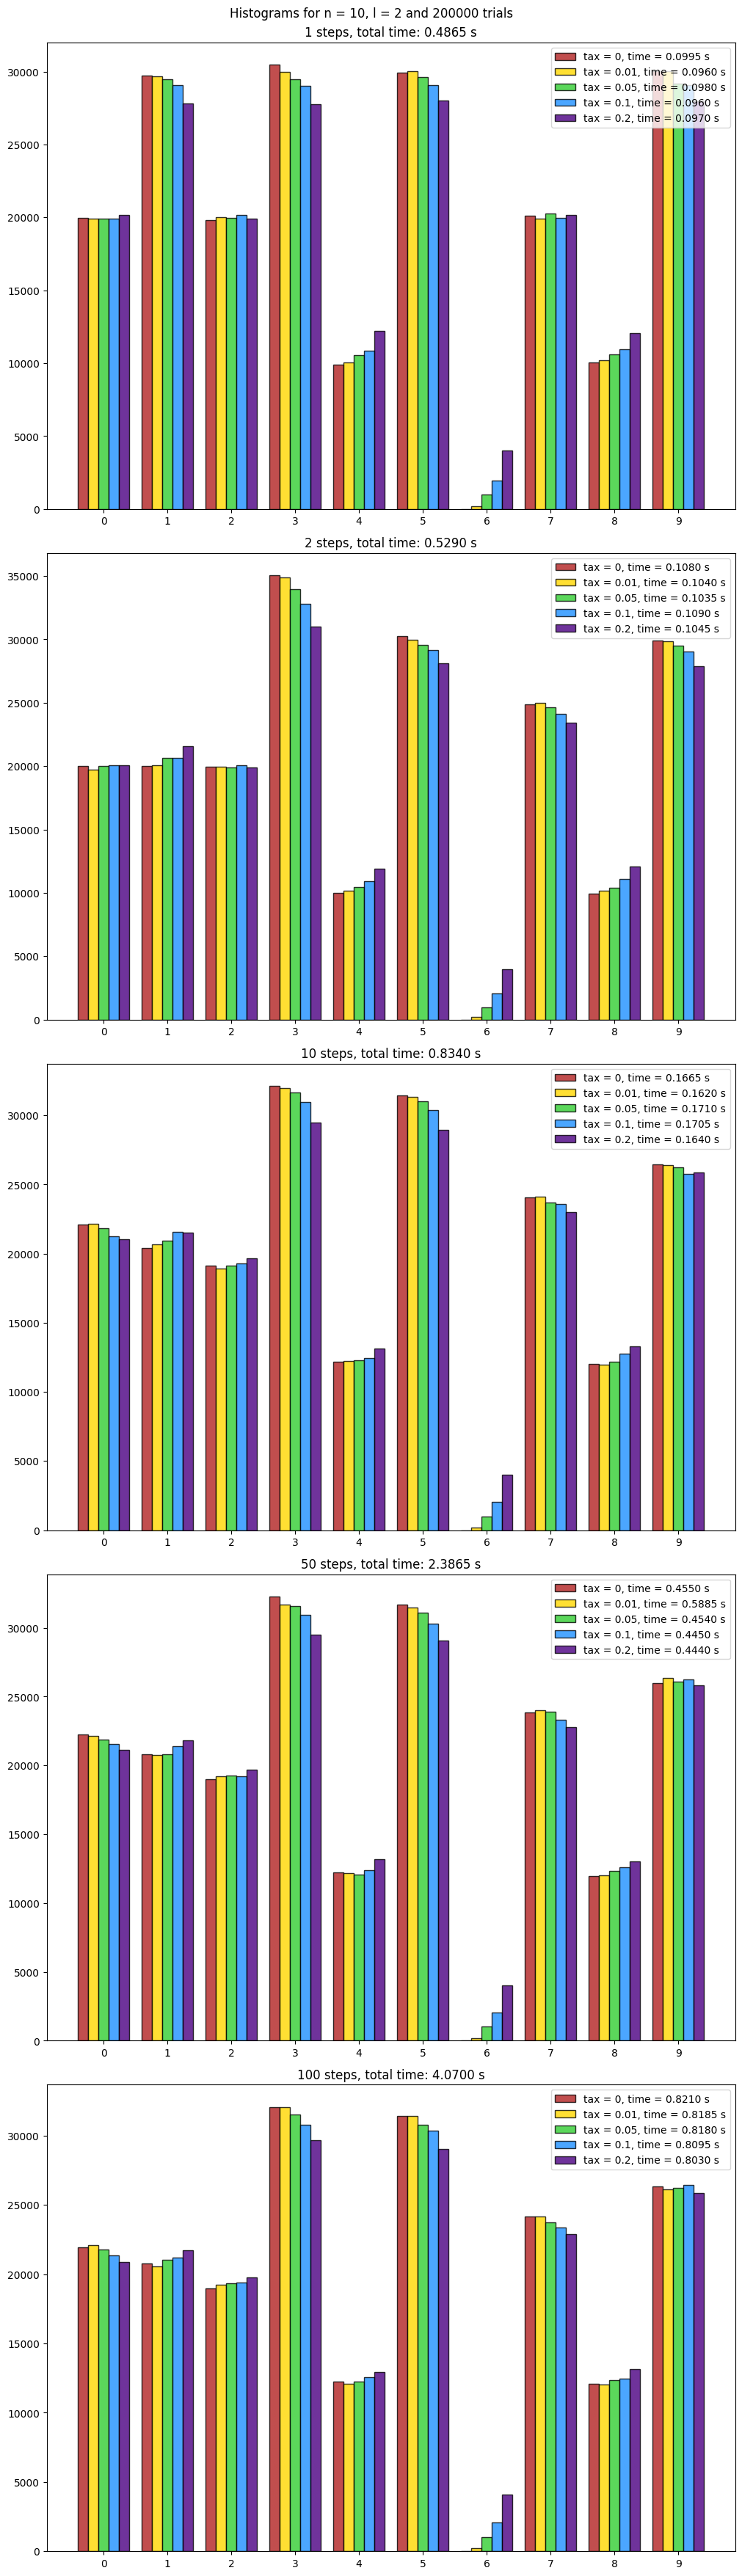

In [15]:
generate_graph_for_given_n_and_l(10, 2, trials)

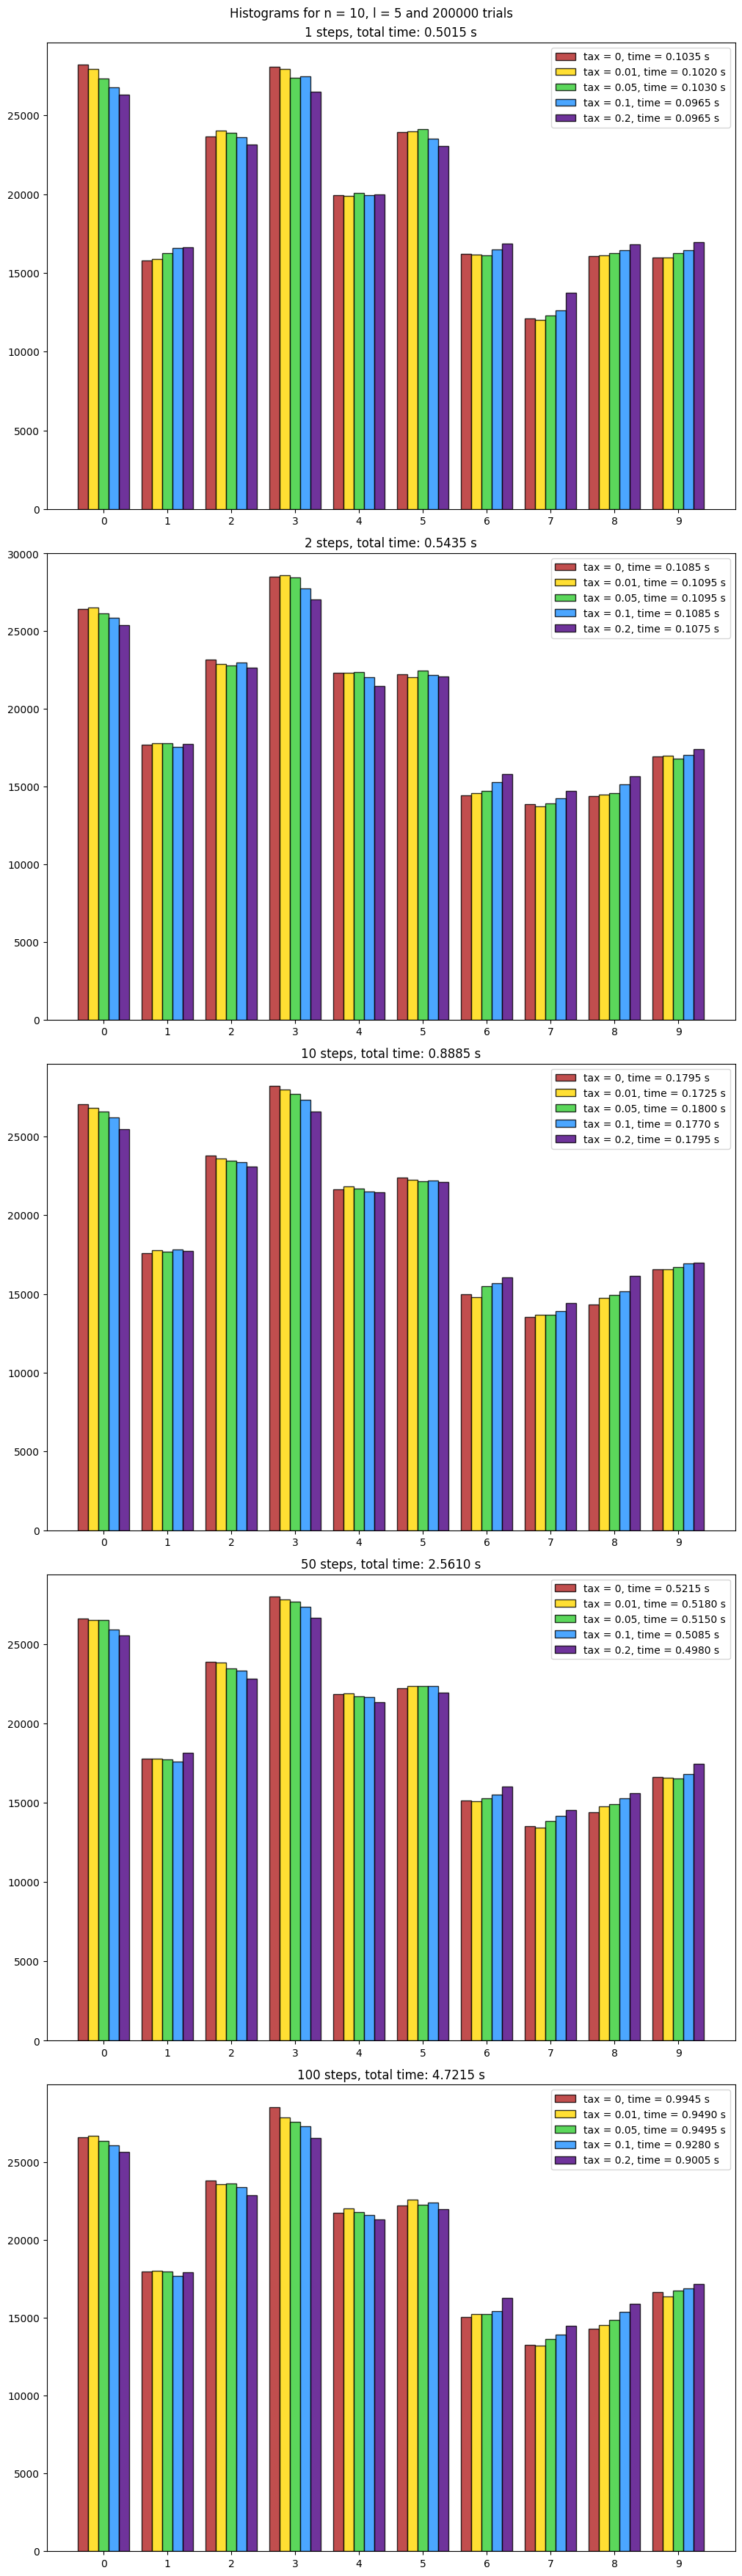

In [16]:
generate_graph_for_given_n_and_l(10, 5, trials)

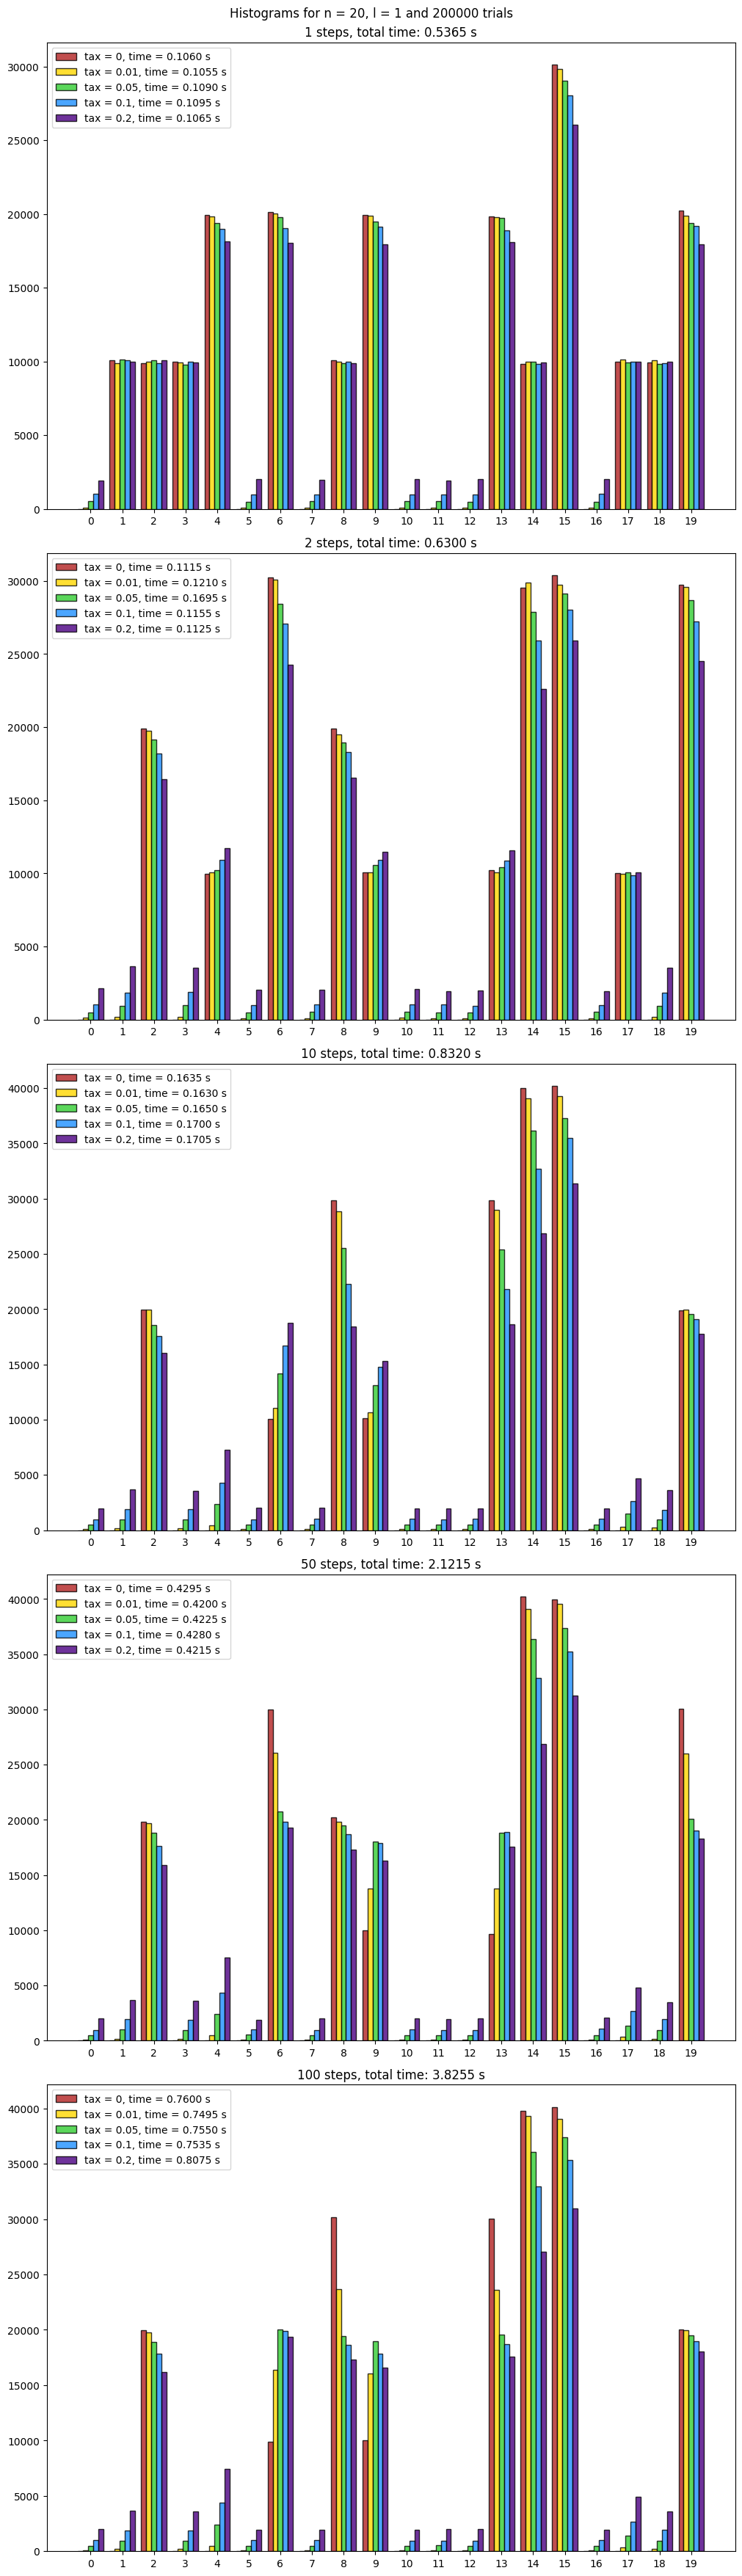

In [17]:
generate_graph_for_given_n_and_l(20, 1, trials)

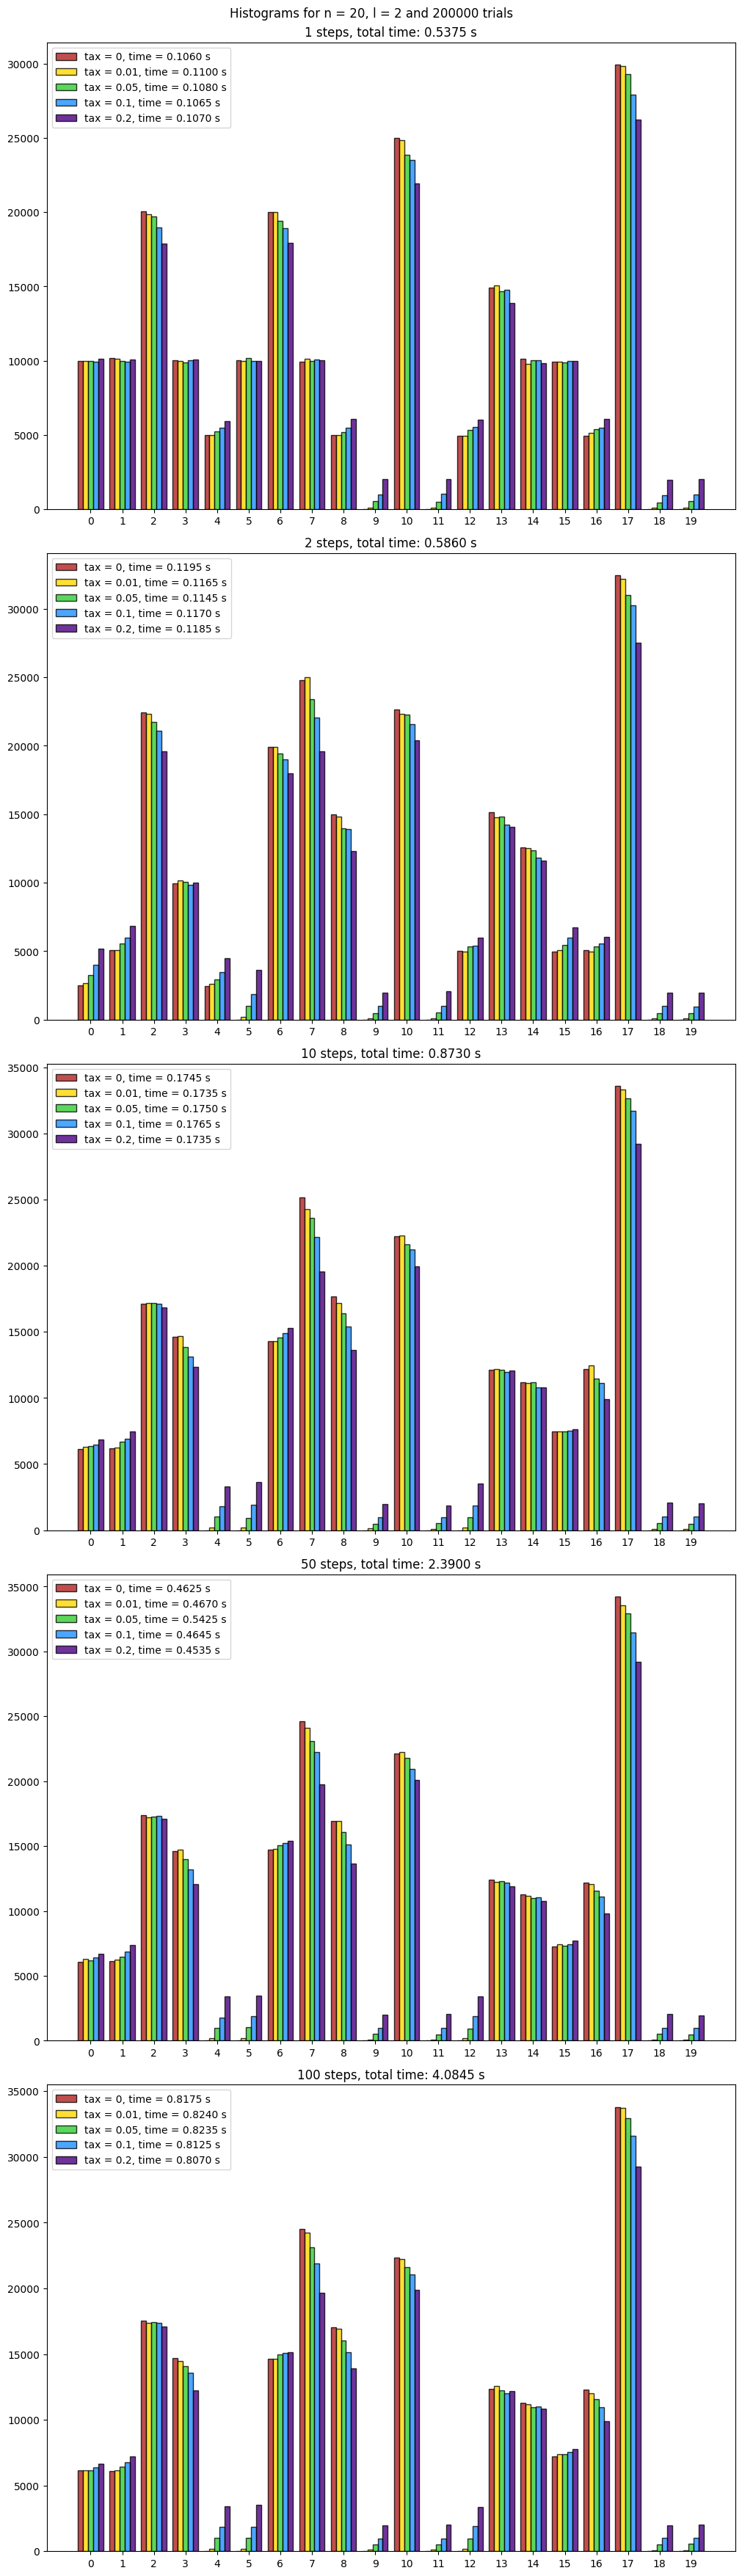

In [18]:
generate_graph_for_given_n_and_l(20, 2, trials)

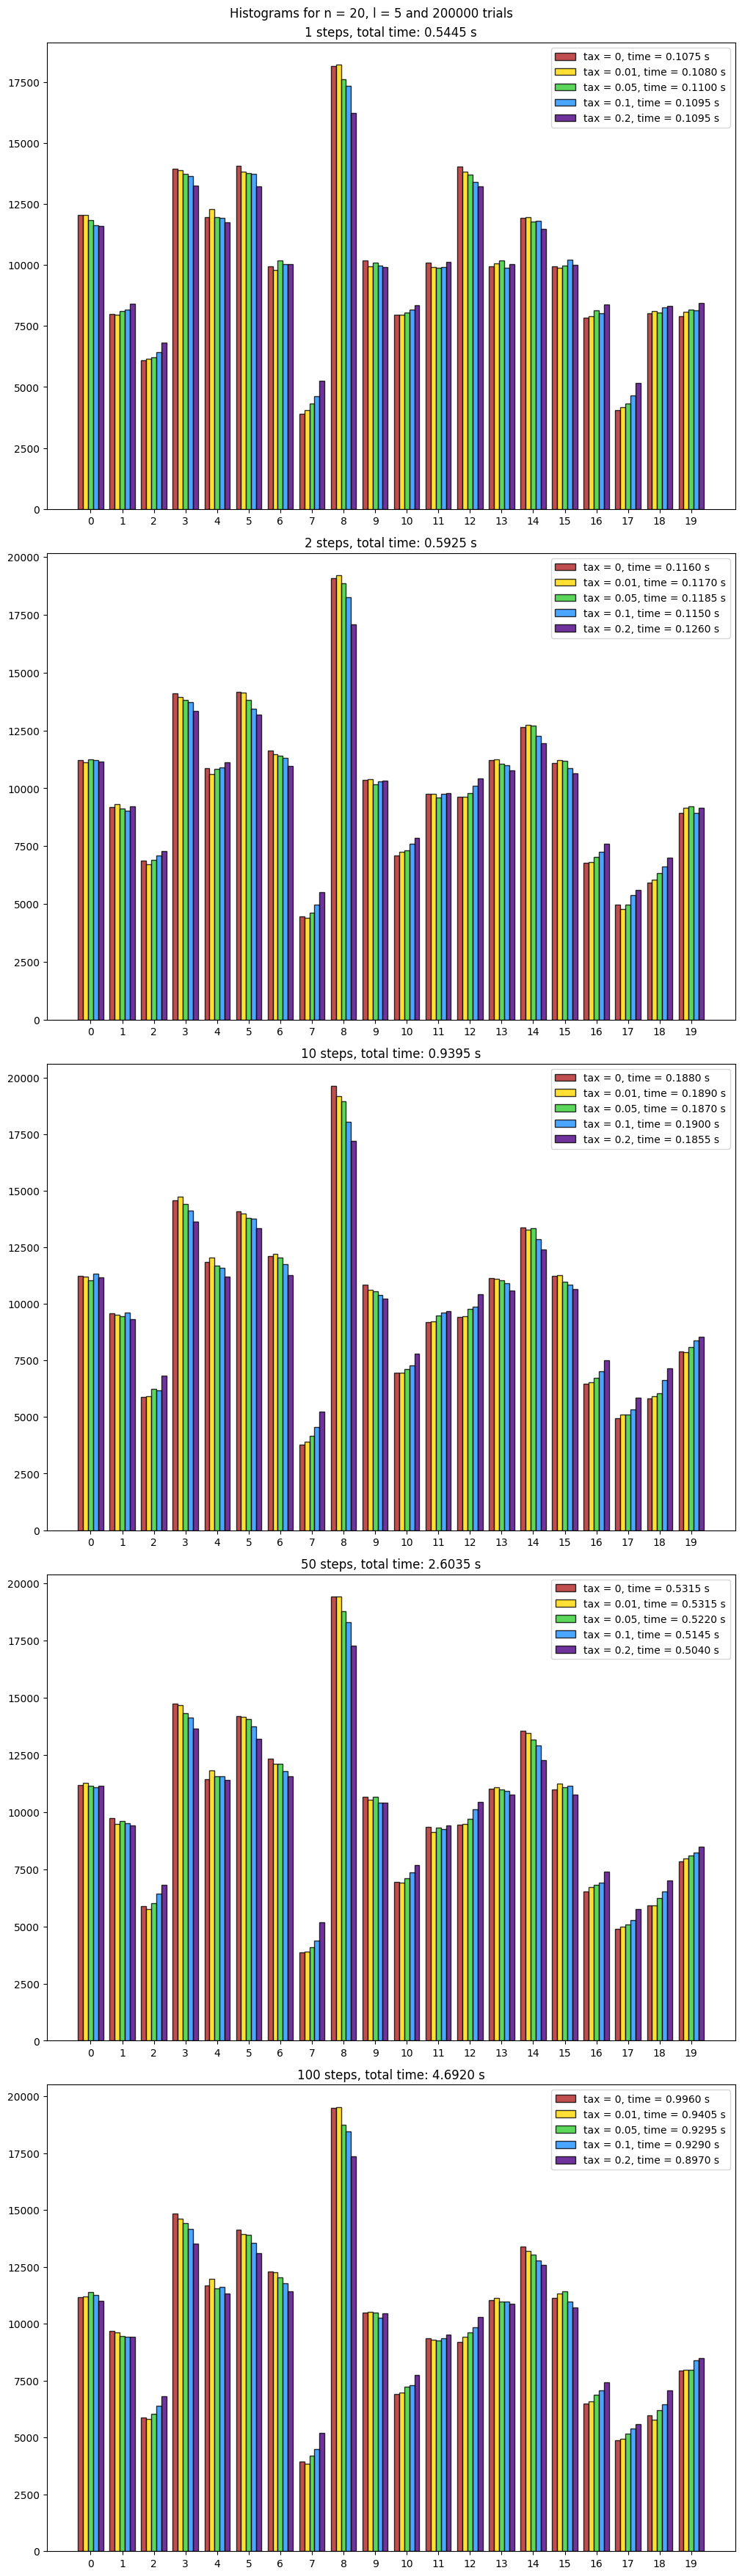

In [19]:
generate_graph_for_given_n_and_l(20, 5, trials)

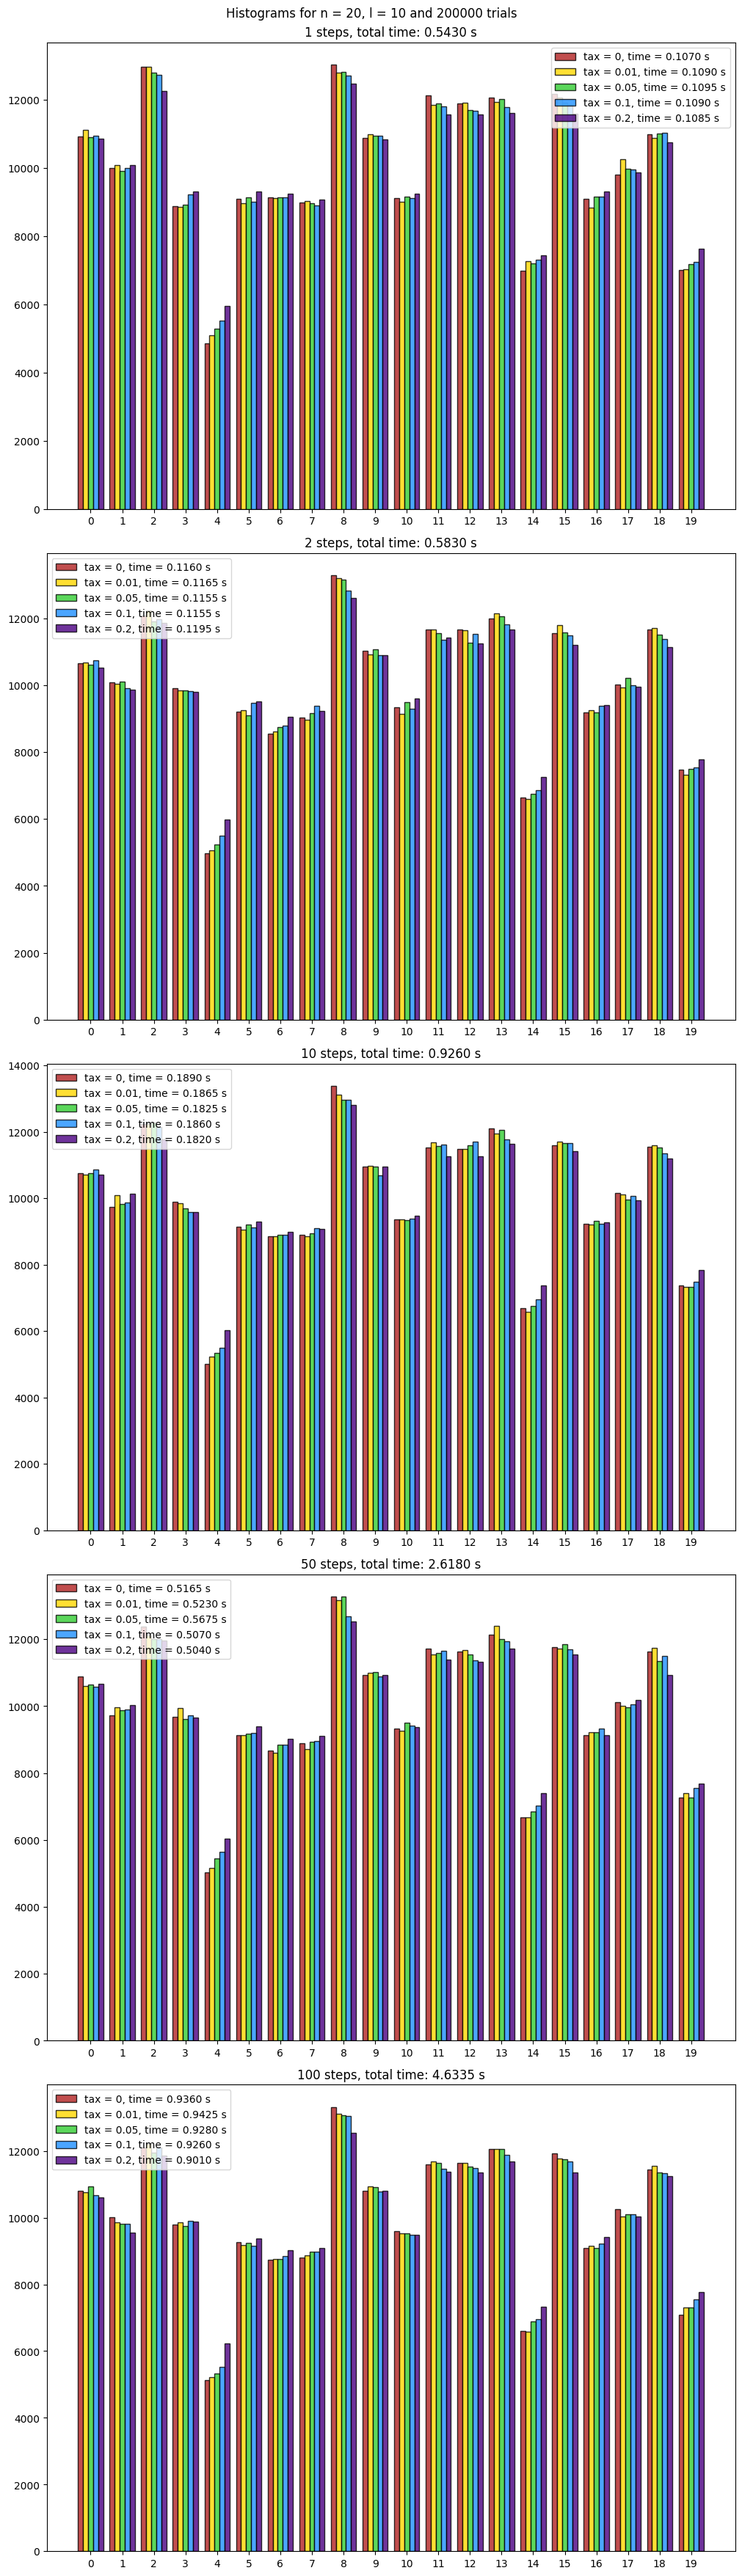

In [20]:
generate_graph_for_given_n_and_l(20, 10, trials)